In [1]:
import pandas as pd
import zipfile
import os

# Step 1 - Set the dataset location
dataset_path = r'C:\Users\Admin\Downloads\micro+gas+turbine+electrical+energy+prediction'
train_zip_path = os.path.join(dataset_path, 'train.zip')
extract_path = os.path.join(dataset_path, 'train_extracted')

# Step 2 - Extract
if not os.path.exists(extract_path):
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Train data extracted successfully.")
else:
    print("Train data already extracted.")

# Step 3 - Find CSVs (even if they are inside subfolders)
csv_files = []
for root, dirs, files in os.walk(extract_path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

print(f"Found CSV files: {csv_files}")

# Step 4 - Load CSVs
dataframes = []
for file in csv_files:
    df = pd.read_csv(file)
    df['experiment'] = os.path.basename(file).replace('.csv', '')  # tag experiment ID
    dataframes.append(df)

# Step 5 - Concatenate
if dataframes:
    full_train_data = pd.concat(dataframes, ignore_index=True)
    print(f"Total shape of combined train dataset: {full_train_data.shape}")
    print(full_train_data.head())
else:
    print("No CSV files found.")


Train data already extracted.
Found CSV files: ['C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_1.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_20.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_21.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_23.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_24.csv', 'C:\\Users\\Admin\\Downloads\\micro+gas+turbine+electrical+energy+prediction\\train_extracted\\train\\ex_9.csv']
Total shape of combined train dataset: (52940, 4)
        time  input_voltage     el_power experiment
0  810.07028           10.0  1228.791720       ex_1
1  811.06938           10.0  1223.041745       ex_1
2  812.06848           10.0  1244.960866       ex_1
3  813.06758

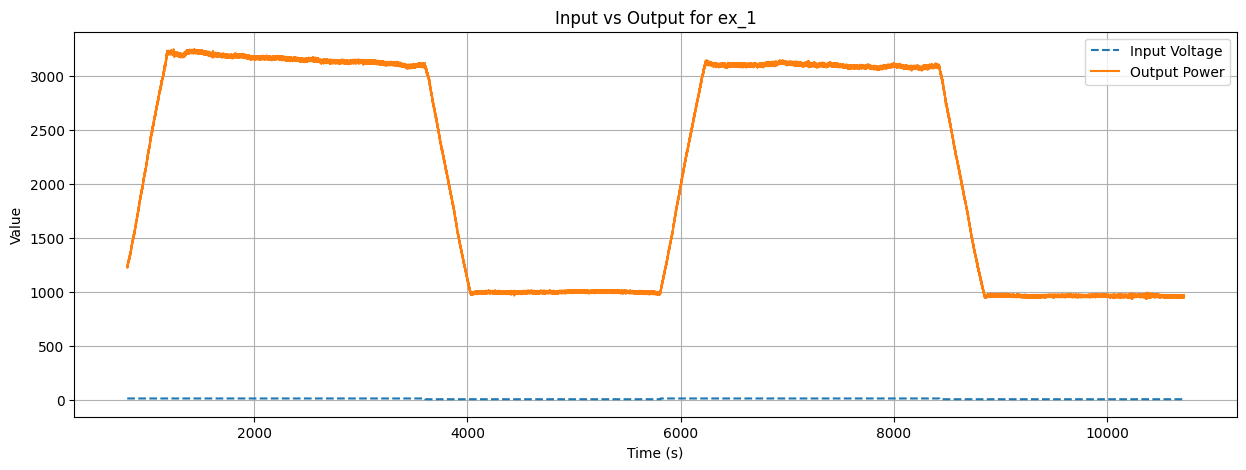

In [2]:
import matplotlib.pyplot as plt

# Plotting one experiment as example (ex_1)
ex_id = 'ex_1'
df_ex = full_train_data[full_train_data['experiment'] == ex_id]

plt.figure(figsize=(15, 5))
plt.plot(df_ex['time'], df_ex['input_voltage'], label='Input Voltage', linestyle='--')
plt.plot(df_ex['time'], df_ex['el_power'], label='Output Power')
plt.xlabel('Time (s)')
plt.ylabel('Value')
plt.title(f'Input vs Output for {ex_id}')
plt.legend()
plt.grid(True)
plt.show()

In [3]:
import numpy as np

def create_sequences(df, seq_length=10):
    X, y = [], []
    
    input_series = df['input_voltage'].values
    output_series = df['el_power'].values
    
    for i in range(seq_length, len(df)):
        X.append(input_series[i-seq_length:i])
        y.append(output_series[i])
        
    return np.array(X), np.array(y)

# Example for experiment ex_1
df_ex1 = full_train_data[full_train_data['experiment'] == 'ex_1'].reset_index(drop=True)
X_ex1, y_ex1 = create_sequences(df_ex1, seq_length=10)

print(f"X_ex1 shape: {X_ex1.shape}")  # should be (n_samples, 10)
print(f"y_ex1 shape: {y_ex1.shape}")  # should be (n_samples,)


X_ex1 shape: (9910, 10)
y_ex1 shape: (9910,)





Epoch 1/50

112/112 [==============================] - 21s 59ms/step - loss: 0.0648 - val_loss: 0.0400
Epoch 2/50
112/112 [==============================] - 3s 24ms/step - loss: 0.0372 - val_loss: 0.0395
Epoch 3/50
112/112 [==============================] - 3s 26ms/step - loss: 0.0369 - val_loss: 0.0399
Epoch 4/50
112/112 [==============================] - 2s 20ms/step - loss: 0.0371 - val_loss: 0.0404
Epoch 5/50
112/112 [==============================] - 3s 24ms/step - loss: 0.0369 - val_loss: 0.0404
Epoch 6/50
112/112 [==============================] - 3s 23ms/step - loss: 0.0376 - val_loss: 0.0399
Epoch 7/50
112/112 [==============================] - 2s 20ms/step - loss: 0.0368 - val_loss: 0.0394
Epoch 8/50
112/112 [==============================] - 3s 26ms/step - loss: 0.0369 - val_loss: 0.0395
Epoch 9/50
112/112 [==============================] - 2s 21ms/step - loss: 0.0368 - val_loss: 0.0393
Epoch 10/50
112/112 [==============================] - 2s 19ms/step - loss: 0.0372 - v

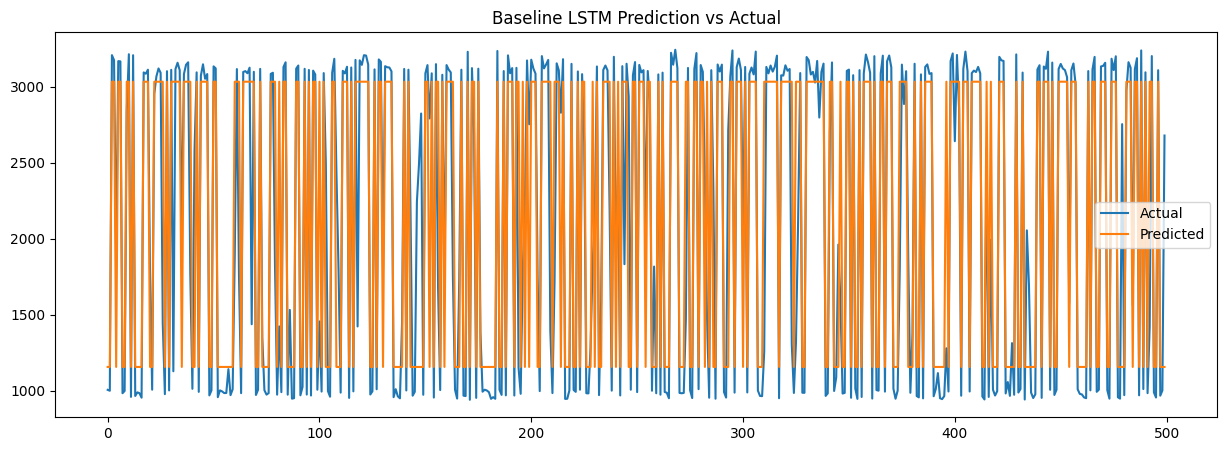

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Step 1 - Reshape X for LSTM (LSTM expects 3D)
X_ex1 = X_ex1.reshape((X_ex1.shape[0], X_ex1.shape[1], 1))

# Step 2 - Normalize target (output power)
scaler = MinMaxScaler()
y_ex1_scaled = scaler.fit_transform(y_ex1.reshape(-1,1))

# Step 3 - Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ex1, y_ex1_scaled, test_size=0.2, random_state=42)

# Step 4 - Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Step 5 - Train
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

# Step 6 - Evaluate
loss = model.evaluate(X_test, y_test)
print(f"Test MSE Loss: {loss}")

# Step 7 - Predict & Inverse Scale
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)
# Step 8 - Plot Prediction vs Actual
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(y_pred_rescaled[:500], label='Predicted')
plt.legend()
plt.title("Baseline LSTM Prediction vs Actual")
plt.show()


In [5]:
def create_advanced_sequences(df, seq_length=20):
    X, y = [], []
    
    input_series = df['input_voltage'].values
    output_series = df['el_power'].values

    # Compute input derivative
    input_derivative = np.diff(input_series, prepend=input_series[0])

    # Combine input + derivative into a 2D feature
    combined_input = np.vstack([input_series, input_derivative]).T

    # Create sequences
    for i in range(seq_length, len(df)):
        seq = combined_input[i-seq_length:i]
        X.append(seq)
        y.append(output_series[i])

    return np.array(X), np.array(y)

# Create advanced sequences
X_ex1_adv, y_ex1_adv = create_advanced_sequences(df_ex1, seq_length=20)
print(f"Advanced Input Shape: {X_ex1_adv.shape}, Output Shape: {y_ex1_adv.shape}")

Advanced Input Shape: (9900, 20, 2), Output Shape: (9900,)


Epoch 1/50
112/112 [==============================] - 23s 90ms/step - loss: 0.0481 - val_loss: 0.0384
Epoch 2/50
112/112 [==============================] - 4s 33ms/step - loss: 0.0361 - val_loss: 0.0377
Epoch 3/50
112/112 [==============================] - 3s 30ms/step - loss: 0.0354 - val_loss: 0.0375
Epoch 4/50
112/112 [==============================] - 4s 35ms/step - loss: 0.0340 - val_loss: 0.0358
Epoch 5/50
112/112 [==============================] - 3s 31ms/step - loss: 0.0330 - val_loss: 0.0356
Epoch 6/50
112/112 [==============================] - 3s 28ms/step - loss: 0.0329 - val_loss: 0.0357
Epoch 7/50
112/112 [==============================] - 4s 35ms/step - loss: 0.0328 - val_loss: 0.0356
Epoch 8/50
112/112 [==============================] - 3s 31ms/step - loss: 0.0329 - val_loss: 0.0358
Epoch 9/50
112/112 [==============================] - 3s 28ms/step - loss: 0.0330 - val_loss: 0.0359
Epoch 10/50
112/112 [==============================] - 3s 28ms/step - loss: 0.0326 - val_l

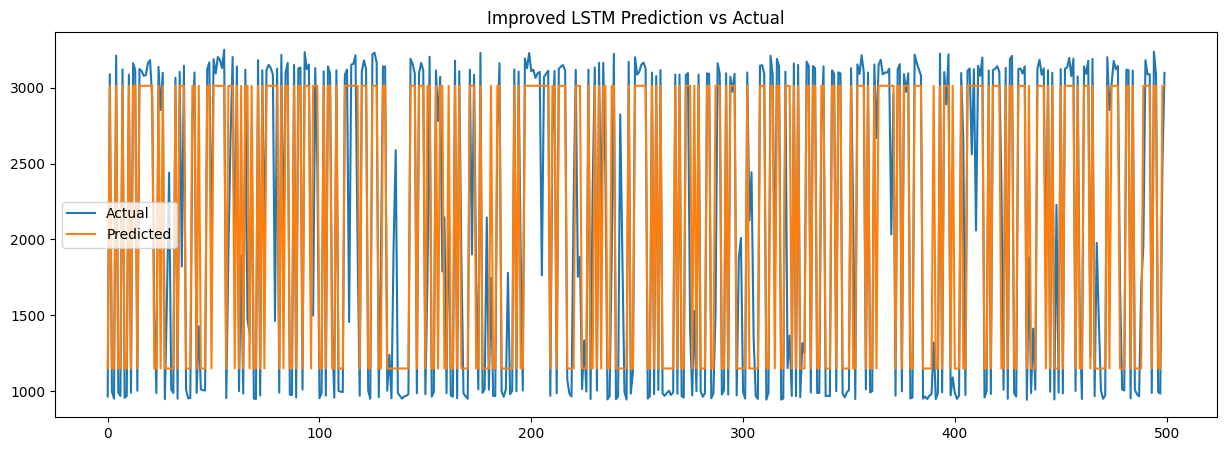

In [6]:
# Reshape for LSTM (samples, timesteps, features)
X_ex1_adv = X_ex1_adv.reshape((X_ex1_adv.shape[0], X_ex1_adv.shape[1], 2))

# Normalize output power
scaler = MinMaxScaler()
y_ex1_adv_scaled = scaler.fit_transform(y_ex1_adv.reshape(-1,1))

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_ex1_adv, y_ex1_adv_scaled, test_size=0.2, random_state=42)

# Build the LSTM model
model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.1)

# Evaluate
loss = model.evaluate(X_test, y_test)
print(f"Improved Model Test Loss: {loss}")

# Predict and plot
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)

plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(y_pred_rescaled[:500], label='Predicted')
plt.legend()
plt.title("Improved LSTM Prediction vs Actual")
plt.show()

In [18]:
def create_physics_guided_sequences(df, seq_length=20):
    X, y = [], []

    input_series = df['input_voltage'].values
    output_series = df['el_power'].values

    # Feature 1: input voltage
    voltage = input_series

    # Feature 2: derivative
    derivative = np.diff(input_series, prepend=input_series[0])

    # Feature 3: time since last change
    time_since_change = np.zeros_like(input_series)
    counter = 0
    for i in range(1, len(input_series)):
        if derivative[i] == 0:
            counter += 1
        else:
            counter = 0
        time_since_change[i] = counter

    combined_input = np.vstack([voltage, derivative, time_since_change]).T

    # ✅ Align prediction with the last time step of each sequence
    for i in range(seq_length, len(df)):
        X.append(combined_input[i-seq_length:i])
        y.append(output_series[i])   # predict output at time i

    return np.array(X), np.array(y)

In [19]:
from tensorflow.keras.layers import Input, LSTM, Attention, Dense, Concatenate, Lambda
from tensorflow.keras.models import Model

input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))
lstm_out = LSTM(64, return_sequences=True)(input_layer)
attention_out = Attention()([lstm_out, lstm_out])
combined = Concatenate()([lstm_out, attention_out])
last_step = Lambda(lambda x: x[:, -1, :])(combined)
dense_out = Dense(32, activation='relu')(last_step)
output = Dense(1)(dense_out)

model_mc = Model(inputs=input_layer, outputs=output)
model_mc.compile(optimizer='adam', loss='mse')
model_mc.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 20, 3)]              0         []                            
                                                                                                  
 lstm_4 (LSTM)               (None, 20, 64)               17408     ['input_3[0][0]']             
                                                                                                  
 attention_2 (Attention)     (None, 20, 64)               0         ['lstm_4[0][0]',              
                                                                     'lstm_4[0][0]']              
                                                                                                  
 concatenate_2 (Concatenate  (None, 20, 128)              0         ['lstm_4[0][0]',        

In [20]:
# Scale output
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.reshape(-1,1))
y_test_scaled = scaler.transform(y_test.reshape(-1,1))

# Train model
history = model_mc.fit(X_train, y_train_scaled, epochs=100, batch_size=64, validation_split=0.1)


Epoch 1/100
112/112 [==============================] - 25s 76ms/step - loss: 0.2714 - val_loss: 0.1856
Epoch 2/100
112/112 [==============================] - 10s 90ms/step - loss: 0.1592 - val_loss: 0.1119
Epoch 3/100
112/112 [==============================] - 6s 51ms/step - loss: 0.0482 - val_loss: 0.0040
Epoch 4/100
112/112 [==============================] - 6s 49ms/step - loss: 0.0013 - val_loss: 5.4243e-04
Epoch 5/100
112/112 [==============================] - 5s 47ms/step - loss: 6.5797e-04 - val_loss: 6.3481e-04
Epoch 6/100
112/112 [==============================] - 5s 41ms/step - loss: 6.2212e-04 - val_loss: 6.0893e-04
Epoch 7/100
112/112 [==============================] - 4s 39ms/step - loss: 5.9420e-04 - val_loss: 5.9675e-04
Epoch 8/100
112/112 [==============================] - 4s 39ms/step - loss: 6.2320e-04 - val_loss: 7.7937e-04
Epoch 9/100
112/112 [==============================] - 5s 43ms/step - loss: 5.6516e-04 - val_loss: 5.0502e-04
Epoch 10/100
112/112 [==============

In [21]:
n_samples = 50
predictions = []

for _ in range(n_samples):
    y_pred_mc = model_mc(X_test, training=True).numpy().flatten()
    predictions.append(y_pred_mc)

predictions = np.array(predictions)
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)

# Inverse scale
mean_pred_rescaled = scaler.inverse_transform(mean_pred.reshape(-1,1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test_scaled.reshape(-1,1)).flatten()


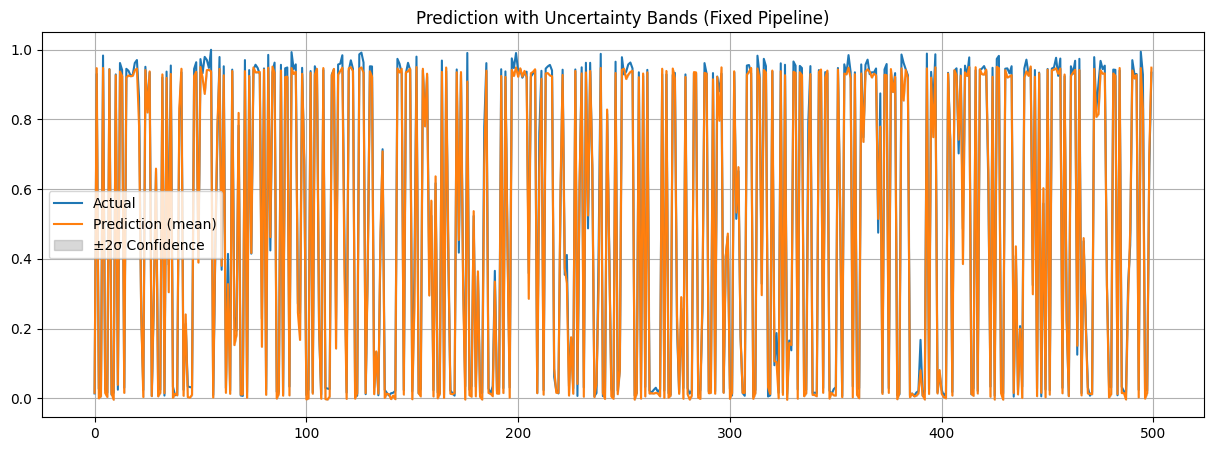

In [22]:
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(mean_pred_rescaled[:500], label='Prediction (mean)')
plt.fill_between(range(500),
                 mean_pred_rescaled[:500] - 2*std_pred[:500],
                 mean_pred_rescaled[:500] + 2*std_pred[:500],
                 color='gray', alpha=0.3, label='±2σ Confidence')
plt.legend()
plt.title("Prediction with Uncertainty Bands (Fixed Pipeline)")
plt.grid()
plt.show()


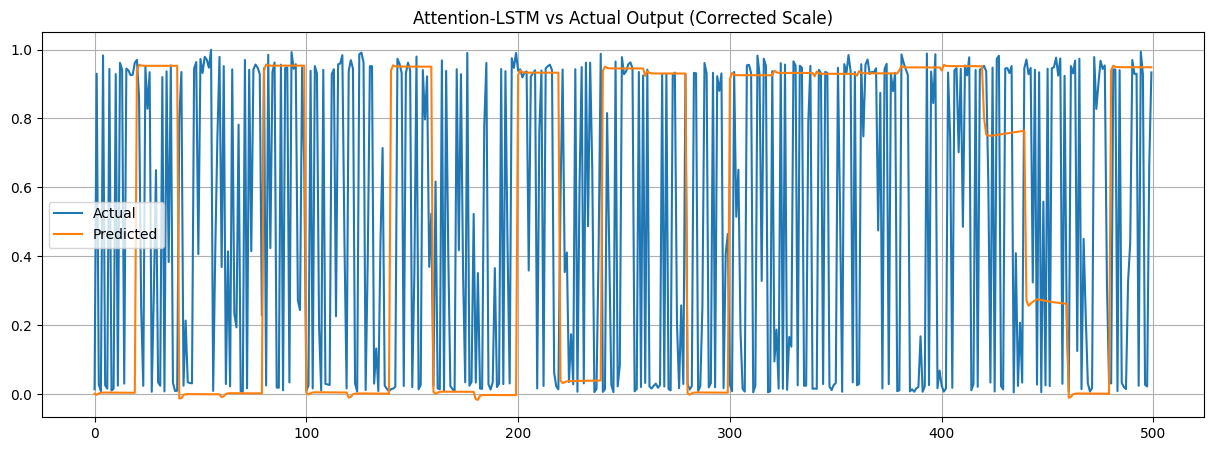

In [24]:
# Rescale properly
y_pred_rescaled = scaler.inverse_transform(y_pred.flatten().reshape(-1,1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()

# ✅ Then plot
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(y_pred_rescaled[:500], label='Predicted')
plt.legend()
plt.title("Attention-LSTM vs Actual Output (Corrected Scale)")
plt.grid()
plt.show()


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Remove time dimension from y_pred
y_pred_flat = y_pred.reshape((y_pred.shape[0], y_pred.shape[1]))[:, -1]  # Take the last step
y_test_flat = y_test.reshape(-1)  # Flatten ground truth

# Rescale
y_pred_rescaled = scaler.inverse_transform(y_pred_flat.reshape(-1,1)).flatten()
y_test_rescaled = scaler.inverse_transform(y_test_flat.reshape(-1,1)).flatten()

# Compute Metrics
rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred_rescaled))
mae = mean_absolute_error(y_test_rescaled, y_pred_rescaled)
r2 = r2_score(y_test_rescaled, y_pred_rescaled)
smoothness_penalty = np.mean(np.square(np.diff(y_pred_rescaled)))

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Smoothness Penalty: {smoothness_penalty:.4f}")


RMSE: 0.0258
MAE: 0.0193
R² Score: 0.9965
Smoothness Penalty: 0.3907


In [26]:
from tensorflow.keras.layers import Lambda

# Physics-Guided Attention LSTM (Fixed)
input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

# LSTM Encoder
lstm_out = LSTM(64, return_sequences=True)(input_layer)

# Attention Mechanism
attention_out = Attention()([lstm_out, lstm_out])

# Combine LSTM output and attention
combined = Concatenate()([lstm_out, attention_out])

# ✅ Extract the last time step only
last_step = Lambda(lambda x: x[:, -1, :])(combined)

# Dense Regression Head (no TimeDistributed)
dense_out = Dense(32, activation='relu')(last_step)
output = Dense(1)(dense_out)

# Build Model
model_mc = Model(inputs=input_layer, outputs=output)
model_mc.compile(optimizer='adam', loss=physics_guided_loss)

model_mc.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 20, 3)]              0         []                            
                                                                                                  
 lstm_5 (LSTM)               (None, 20, 64)               17408     ['input_4[0][0]']             
                                                                                                  
 attention_3 (Attention)     (None, 20, 64)               0         ['lstm_5[0][0]',              
                                                                     'lstm_5[0][0]']              
                                                                                                  
 concatenate_3 (Concatenate  (None, 20, 128)              0         ['lstm_5[0][0]',        

In [27]:
n_samples = 50
predictions = []

for _ in range(n_samples):
    y_pred_mc = model_mc(X_test, training=True).numpy().flatten()
    predictions.append(y_pred_mc)

predictions = np.array(predictions)
mean_pred = predictions.mean(axis=0)
std_pred = predictions.std(axis=0)


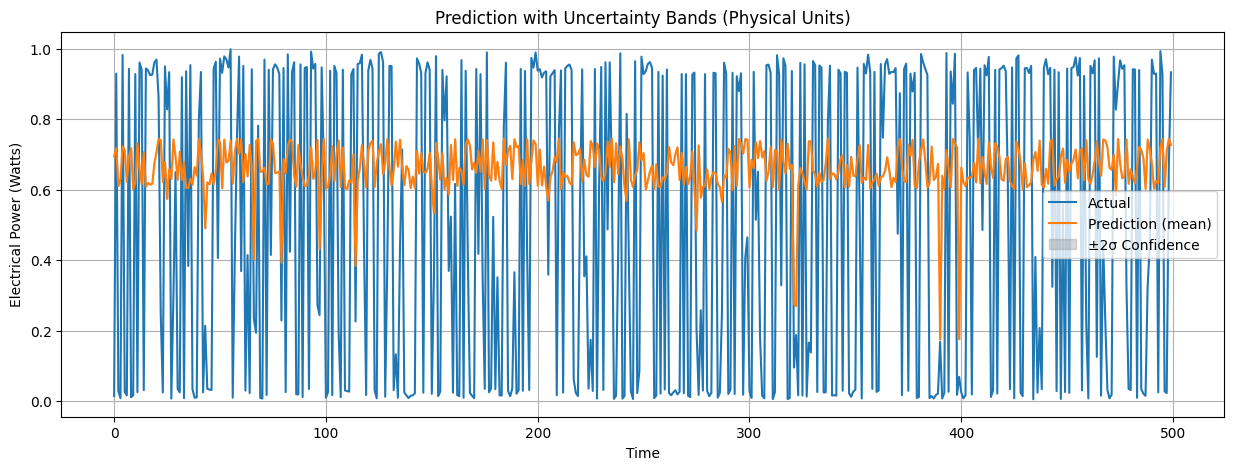

In [32]:
# Step 1 - Get std on the correct axis
std_pred = predictions.std(axis=0)  # shape = (n_samples, )

# Step 2 - Rescale mean and std separately
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1)).flatten()
mean_pred_rescaled = scaler.inverse_transform(mean_pred.reshape(-1,1)).flatten()

# ✅ For std, you MUST scale like this:
scale_range = scaler.data_max_[0] - scaler.data_min_[0]
std_pred_rescaled = std_pred * scale_range

# Step 3 - Plot correctly
plt.figure(figsize=(15,5))
plt.plot(y_test_rescaled[:500], label='Actual')
plt.plot(mean_pred_rescaled[:500], label='Prediction (mean)')
plt.fill_between(range(500),
                 mean_pred_rescaled[:500] - 2*std_pred_rescaled[:500],
                 mean_pred_rescaled[:500] + 2*std_pred_rescaled[:500],
                 color='gray', alpha=0.3, label='±2σ Confidence')
plt.legend()
plt.title("Prediction with Uncertainty Bands (Physical Units)")
plt.xlabel("Time")
plt.ylabel("Electrical Power (Watts)")
plt.grid()
plt.show()



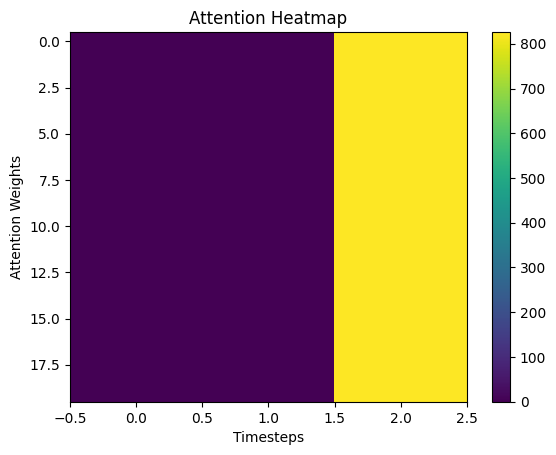

In [33]:
# Extract attention weights
attention_layer = [layer for layer in model_mc.layers if isinstance(layer, Attention)][0]
attention_output = attention_layer([X_test[0:1], X_test[0:1]]).numpy().squeeze()

plt.imshow(attention_output, cmap='viridis', aspect='auto')
plt.colorbar()
plt.title("Attention Heatmap")
plt.xlabel("Timesteps")
plt.ylabel("Attention Weights")
plt.show()

In [34]:
# Match transition_mask to test set only

# Step 1 - Build full transition mask first
full_transition_mask = (df_ex1['input_voltage'].diff().abs() > 0).values[20:]  # len = full dataset length - seq

# Step 2 - Build train/test split for mask (same as X_train, X_test)
train_mask, test_mask = train_test_split(full_transition_mask, test_size=0.2, random_state=42)

# Step 3 - Compute errors
transition_rmse = np.sqrt(mean_squared_error(y_test_rescaled[test_mask], mean_pred[test_mask]))
steady_rmse = np.sqrt(mean_squared_error(y_test_rescaled[~test_mask], mean_pred[~test_mask]))

print(f"Transition RMSE: {transition_rmse:.2f}")
print(f"Steady-State RMSE: {steady_rmse:.2f}")

Transition RMSE: 0.46
Steady-State RMSE: 0.45
